# Salary Prediction Model Report

## Table of Contents

1. [Introduction](#introduction)  
2. [Project Setup & Kedro Context](#setup)  
3. [Data Overview](#data-overview)  
   - 3.1. [Raw Datasets](#raw-datasets)  
   - 3.2. [Target Variable](#target-variable)  
   - 3.3. [Missing Data & Quality Checks](#missing-data)  
4. [Preprocessing & Feature Engineering](#feature-engineering)  
   - 4.1. [Preprocessing Versions](#preprocessing-versions)    
5. [Modeling Approach](#modeling-approach)  
   - 5.1. [Baseline & Linear Models](#baseline-linear)  
   - 5.2. [Regularized Models (Lasso, ElasticNet)](#regularized-models)  
   - 5.3. [Tree-Based Models (RF, XGBoost)](#tree-models)  
   - 5.4. [Hyperparameter Optimization](#hyperparameter-optimization)  
   - 5.5. [SHAP-Based Feature Selection](#shap-selection)  
6. [Model Evaluation](#evaluation)  
   - 6.1. [Evaluation Metrics](#metrics-explained)  
   - 6.2. [Confidence Intervals](#confidence-intervals)  
   - 6.3. [Performance Comparison Table](#comparison-table)  
7. [Best Model Deep Dive](#best-model)  
   - 7.1. [Feature Importance (SHAP)](#feature-importance)  
   - 7.2. [Residual Analysis](#residual-analysis)  
8. [Conclusion & Next Steps](#conclusion)  

## 1. Introduction

This project was developed as part of a technical challenge. The goal is to design, implement, and evaluate a machine learning model capable of predicting an individual's salary based on structured features provided in a public dataset.

The dataset includes the following columns:
- Age
- Gender
- Education level
- Job title
- Years of experience
- Description (free-text field)

The predictive task is to estimate the salary from these features, using Python-based tools and best practices in modular code development.

### Challenge Goals

The technical requirements for the challenge included:
- Developing a predictive model with a clean and modular Python codebase
- Applying preprocessing and feature transformations
- Evaluating model performance using appropriate metrics and confidence intervals
- Including a clear comparison with a sensible baseline (e.g., DummyRegressor)
- Presenting final results in a well-documented Jupyter Notebook
- Hosting the solution in a public GitHub repository

### Project Design Overview

To address the challenge in a structured and scalable way, this project was implemented using **[Kedro](https://kedro.org/)** — a Python framework for reproducible, modular data science workflows.

The core of this project is divided into:
1. **Preprocessing Pipelines**: Structured in two alternative versions (v1 and v2) to experiment with different feature engineering strategies.
2. **Modeling Pipeline**: Trains and evaluates a wide range of regressors, including baseline, linear, regularized, and tree-based models.
3. **Reporting Pipeline**: Aggregates and visualizes model performance, selects top models, and explains results using tools like SHAP.

Although the dataset includes a free-text `description` field, it was **intentionally excluded** from the modeling process in this version, to focus on structured features and simplify the development pipeline.


<a id="setup"></a>
## 2. Project Setup & Kedro Context

This project follows a modular structure using **Kedro**, which organizes code into independent pipelines for data preprocessing, modeling, and reporting.

The directory structure includes:
- `src/salary_prediction/pipelines/data_processing`: Data cleaning, splitting, and feature engineering (v1 and v2)
- `src/salary_prediction/pipelines/data_science`: Model training, hyperparameter optimization, SHAP analysis
- `src/salary_prediction/pipelines/reporting`: Visualization, model comparison, and selection

Kedro allows us to:
- Run partial pipelines with version control
- Pass parameters via `parameters.yml`
- Use a `DataCatalog` to manage datasets cleanly




In [1]:
# Load the Kedro context so we can interact with the pipelines and datasets from within the notebook.
from pathlib import Path
from kedro.framework.hooks import _create_hook_manager
from kedro.framework.project import configure_project
from kedro.framework.context import KedroContext
from kedro.config import OmegaConfigLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Set up Kedro project context
project_path = Path.cwd().parents[0]  # If your notebook is in ./notebooks
configure_project("salary_prediction")

conf_path = project_path / "conf"
env = "local"
config_loader = OmegaConfigLoader(conf_source=str(conf_path))
hook_manager = _create_hook_manager()

context = KedroContext(
    package_name="salary_prediction",
    project_path=project_path,
    config_loader=config_loader,
    hook_manager=hook_manager,
    env=env,
)

catalog = context.catalog
print("Kedro context initialized successfully.")

[04/16/25 09:23:59] INFO     Using                                                                  ]8;id=761505;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/framework/project/__init__.py\__init__.py]8;;\:]8;id=921099;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/framework/project/__init__.py#270\270]8;;\
                             '/home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/                
                             site-packages/kedro/framework/project/rich_logging.yml' as logging                    
                             configuration.                                                                        

[04/16/25 09:24:00] WARNING  /home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/s ]8;id=665413;file:///usr/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=514628;file:///usr/lib/python3.12/warnings.py#110\110]8;;\
                             ite-packages/kedro/io/data_catalog.py:165: KedroDeprecationWarning:                   
                             `DataCatalog` has been deprecated and will be replaced by                             
                             `KedroDataCatalog`, in Kedro 1.0.0.Currently some `KedroDataCatalog`                  
                             APIs have been retained for compatibility with `DataCatalog`,                         
                             including the `datasets` property and the `get_datasets`,                             
                             `_get_datasets`, `add`,` list`, `add_feed_dict`, and `shallow_copy`                   
                             methods. These will be removed or replaced with updated alternatives                  
                             in Kedro 1.0.0. For more details, refer to the documentation:                         
                             https://docs.kedro.org/en/stable/data/index.html#kedrodatacatalog-expe                
                             rimental-feature                                                                      
                               warnings.warn(                                                                      
                                                                                                                   

Kedro context initialized successfully.


## 3. Data Overview

**Note: A detailed Exploratory Data Analysis (EDA) was conducted in a separate notebook (`notebooks/01_EDA.ipynb`). In the EDA, we explored the structure and quality of the datasets, identified missing values, and analyzed the distribution and relationships of key features with salary. We found strong correlations with age, experience, and education, grouped job titles for better modeling, and tested feature interactions. Random Forest models benefited most from including all engineered features and interactions.**


The original dataset includes records for individuals with the following fields:

- `Age`
- `Gender`
- `Education Level`
- `Job Title`
- `Years of Experience`
- `Description` (free text)
- `Salary` (target)

In this challenge, we chose to **exclude the `Description` field** to focus solely on structured features. Future iterations could experiment with NLP techniques to incorporate this field.

### 3.1. Raw Datasets

Dataset composition:
- Total number of samples: 375
- Salary dataset: 375 rows, 2 columns (id, Salary)
- People dataset: 375 rows, 6 columns (id, Age, Gender, Education Level, Job Title, Years of Experience)

Education Levels:
- Bachelor's: 222 samples
- Master's: 97 samples
- PhD: 51 samples

Job Titles:
- Diverse range of job titles (50+ unique titles)
- Top job titles include:
  - Director of Marketing (12 samples)
  - Director of Operations (10 samples)

Additional Features:
- Age: Numeric value indicating age
- Gender: Male and Female
- Years of Experience: Numeric value indicating years of working experience




### 3.2. Target Variable

Salary Distribution:
- Total valid salary entries: 373 (2 null values)
- Mean Salary: $100,577
- Median Salary: $95,000
- Salary Range: $350 - $250,000
- Standard Deviation: $48,240


In [2]:
salary_raw = catalog.load("salary_raw")
salary_raw.describe()

                    INFO     Loading data from salary_raw (CSVDataset)...                       ]8;id=417616;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=46642;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py#401\401]8;;\

,id,Salary
count,375.000000,373.000000
mean,187.000000,100577.345845
std,108.397417,48240.013482
min,0.000000,350.000000
25%,93.500000,55000.000000
50%,187.000000,95000.000000
75%,280.500000,140000.000000
max,374.000000,250000.000000


                    INFO     Loading data from salary_raw (CSVDataset)...                       ]8;id=161811;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=955142;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py#401\401]8;;\

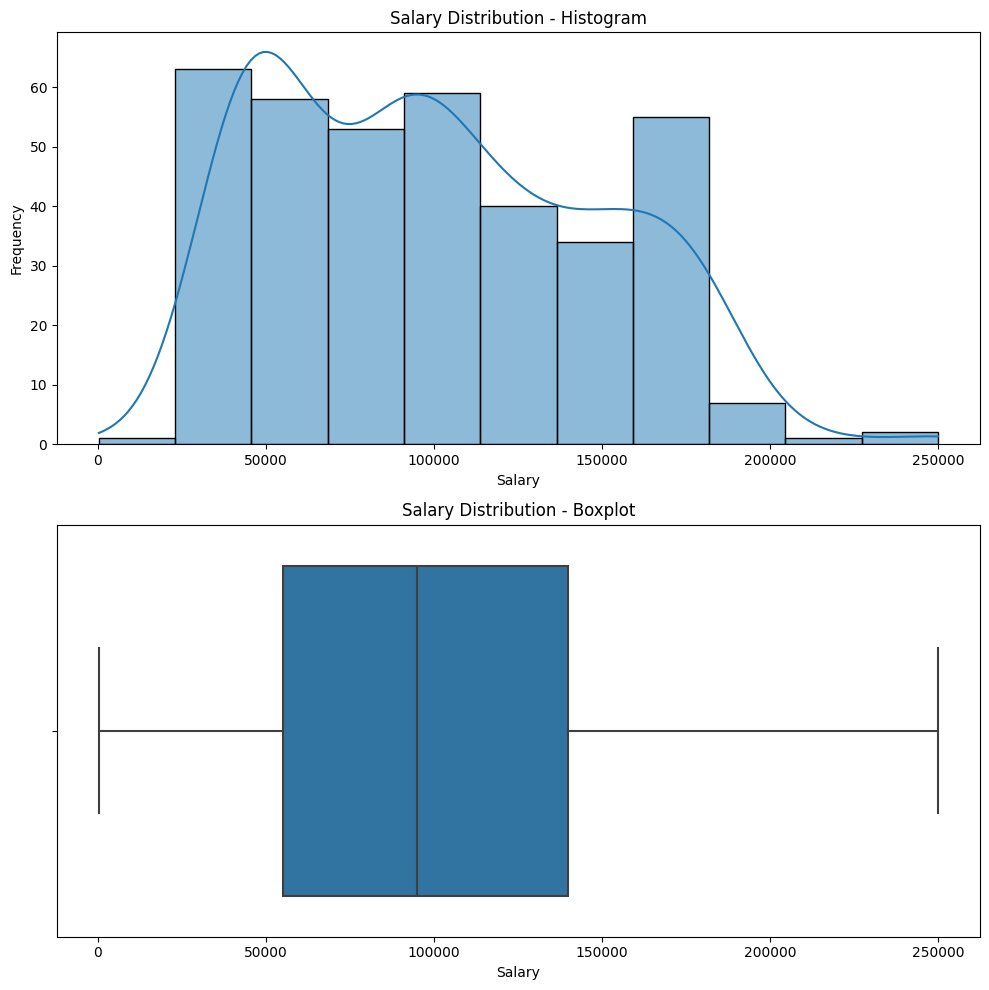

Skewness: 0.400578053273342


In [3]:
# Distribution of the target variable
salary_df = catalog.load("salary_raw")

plt.figure(figsize=(10, 10))

# Histogram
plt.subplot(2, 1, 1)
sns.histplot(salary_df['Salary'], kde=True)
plt.title('Salary Distribution - Histogram')
plt.xlabel('Salary')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(2, 1, 2)
sns.boxplot(x=salary_df['Salary'], orient='h')
plt.title('Salary Distribution - Boxplot')
plt.xlabel('Salary')

plt.tight_layout()
plt.show()


print(f"Skewness: {salary_raw['Salary'].skew()}")

**Key Observations:**
- The distribution is slightly right-skewed. Salary tend to be clustered towards the lower end. Seems to not be skewed enough to necessarily require transformation.
- The range spans from \$350 to \$250,000.
- High variance (std ≈ \$48K) suggests wide differences in compensation.
- 2 missing values (0.53%) → easily manageable.

### 3.3. Missing Data & Quality Checks
Missing Data in Salary Dataset:
- Total samples: 375
- Valid salary entries: 373
- Missing salary entries: 2 (0.53% of the dataset)
- Note from EDA: "Two null salary -> Remove in the data processing steps"

Missing Data in People Dataset:
- Education Level: Contains nan values
- Total samples: 375
- Bachelor's: 222
- Master's: 97
- PhD: 51
- Unspecified/Missing: Some nan entries present

Missing Data in Job Title:
- Job Title column also contains nan entries
- Multiple unique job titles (50+ different titles)
- Some job titles have missing values

Data Quality Observations:
- Consistent id column across datasets
- Salary range: $350 - $250,000
- Salary has a standard deviation of $48,240
- Age and Years of Experience have nans

**Missing data in features table 'people_raw'**

In [4]:
# Load dataset
df_people = catalog.load("people_raw")

# Create a summary DataFrame for missing values
missing_summary = (
    df_people.isnull()
    .sum()
    .reset_index()
    .rename(columns={'index': 'Column', 0: 'Missing Count'})
)
missing_summary['% Missing'] = (missing_summary['Missing Count'] / len(df_people) * 100).round(2)
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]  # Only show columns with missing values

missing_summary


[04/16/25 09:24:01] INFO     Loading data from people_raw (CSVDataset)...                       ]8;id=743374;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=913553;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py#401\401]8;;\

,Column,Missing Count,% Missing
1,Age,5,1.33
2,Gender,5,1.33
3,Education Level,5,1.33
4,Job Title,5,1.33
5,Years of Experience,2,0.53


The table below outlines the percentage and count of missing values in the people_raw dataset. All features have less than 2% missingness, which is manageable through imputation strategies described in the preprocessing section.

**Missing data in target variable 'Salary'**

In [5]:
# Load dataset
df_salary = catalog.load("salary_raw")

# Create a summary DataFrame for missing values
missing_summary = (
    df_salary.isnull()
    .sum()
    .reset_index()
    .rename(columns={'index': 'Column', 0: 'Missing Count'})
)
missing_summary['% Missing'] = (missing_summary['Missing Count'] / len(df_people) * 100).round(2)
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]  # Only show columns with missing values

missing_summary

                    INFO     Loading data from salary_raw (CSVDataset)...                       ]8;id=961478;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=985357;file:///home/cristian/repos/challenge-salary-prediction/venv/lib/python3.12/site-packages/kedro/io/data_catalog.py#401\401]8;;\

,Column,Missing Count,% Missing
1,Salary,2,0.53


**Review the `notebooks/01_EDA.ipynb` notebook with the exploratory data analysis**

## 4. Preprocessing & Feature Engineering

To ensure consistent and high-quality inputs for modeling, the project defines two alternative preprocessing pipelines. Both pipelines share a common initial preprocessing stage followed by a versioned transformation step, enabling experimentation with multiple feature engineering strategies.

### Common Preprocessing Steps

All preprocessing versions begin with a shared set of operations:
- Merging datasets: The people and salary datasets are joined on the 'id' column.
- Cleaning: Duplicate rows are removed and entries with missing target values are dropped.
- Train-test split: Features and target are separated, and the data is split, with a configurable random seed for reproducibility.

### Preprocessing Pipelines
Two distinct pipelines are defined for transforming features:

- Version 1 (v1): Basic Pipeline. This pipeline serves as a baseline with minimal transformation logic to retain interpretability and test model robustness on less processed features.
  - Missing value imputation:
    - Numerical columns: median strategy.
    - Categorical columns: most frequent value.
  - Encoding:
    - Low-cardinality categorical features: One-Hot Encoding (with drop="first" to avoid multicollinearity).
    - High-cardinality features: encoded using Ordinal Encoding (with unknown_value=-1 to handle unseen categories).
  - All numerical features are scaled using StandardScaler (zero mean, unit variance).

   
- Version 2 (v2): Enhanced Pipeline. This version introduces more advanced feature engineering techniques to enrich the dataset with domain-specific transformations and improved encoding strategies
  - Job Title Grouping: Job titles are categorized into hierarchical groups based on both seniority (e.g., Junior, Senior, Executive) and department (e.g., Technical, HR, Marketing). This new JobTitleGroup feature replaces the original raw title to reduce cardinality while preserving semantic meaning.
  - Optional interaction features (configurable via parameters):
    - Age × Years of Experience: Captures non-linear relationships between maturity and experience.
    - Education Level × Years of Experience: Combines formal education with practical experience using an ordinal mapping.
  - Missing value imputation:
    - Numerical columns: imputed using the median.
    - Categorical columns (including grouped job titles and education): imputed using the most frequent value.
  - Encoding:
    - Education Level: encoded using Ordinal Encoding with a predefined hierarchy (e.g., Bachelor's < Master's < PhD).
    - Grouped job titles and low-cardinality features: encoded using One-Hot Encoding (with drop="first" to avoid redundancy).
  - Feature scaling:
    - All numerical features are scaled using StandardScaler (zero mean, unit variance).


#### Feature Treatment Summary by Pipeline

| Feature                     | Type                  | v1: Basic Pipeline                                                              | v2: Enhanced Pipeline                                                                 |
|-----------------------------|-----------------------|----------------------------------------------------------------------------------|----------------------------------------------------------------------------------------|
| `Age`                       | Numerical             | Median imputation → StandardScaler                                              | Median imputation → StandardScaler                                                    |
| `Years of Experience`       | Numerical             | Median imputation → StandardScaler                                              | Median imputation → StandardScaler                                                    |
| `Gender`                    | Low-card Categorical  | Mode imputation → OneHotEncoder (drop="first")                                  | Mode imputation → OneHotEncoder (drop="first")                                        |
| `Education Level`           | Ordinal Categorical   | Mode imputation → OneHotEncoder (drop="first")                                  | Mode imputation → OrdinalEncoder (predefined order, unknown → -1)                     |
| `Job Title`                 | High-card Categorical | Mode imputation → OrdinalEncoder (unknown → -1)                                 | ❌ Dropped — replaced by `JobTitleGroup`                                               |
| `JobTitleGroup`             | Derived Categorical   | ❌ Not present                                                                   | Derived from `Job Title` → Mode imputation → OneHotEncoder (drop="first")             |
| `Age × Experience`          | Interaction           | ❌ Not included                                                                  | Optional (via parameter) → Created + StandardScaler                                   |
| `Education × Experience`    | Interaction           | ❌ Not included                                                                  | Optional (via parameter) → Ordinal × Experience → StandardScaler                      |
| Other low-card categoricals | Categorical           | Mode imputation → OneHotEncoder (drop="first")                                  | Mode imputation → OneHotEncoder (drop="first")                                        |
| Other high-card categoricals| Categorical           | Mode imputation → OrdinalEncoder (unknown → -1)                                 | Mode imputation → OrdinalEncoder (unknown → -1)                                       |

## 5. Modeling Approach

This section details the various regression models developed to predict salaries based on two preprocessing versions (v1 and v2). Models span from simple baselines to complex tree-based ensembles, including hyperparameter tuning and feature selection strategies.

### 5.1. Baseline & Linear Models
To establish a performance benchmark, a DummyRegressor was used, which predicts the mean salary regardless of input. This sets the lower bound for model performance.

Subsequently, a Linear Regression model was trained on the preprocessed features. This model serves as a simple yet interpretable baseline leveraging all numeric and encoded categorical variables without regularization.

- Assumptions of Linear Regression:
  - Linearity: The relationship between features and the target is linear.
  - Independence: Observations are independent.
  - Homoscedasticity: Constant variance of errors across all levels of the independent variables.
  - Normality of residuals: Residuals are normally distributed.
  - No multicollinearity: Features are not highly correlated.

- Assessment:
  - Partially met. Independence and linearity may be reasonable for some features like "Age" or "Experience", but overall, salary prediction often involves non-linearities (e.g., education-job title interactions).
  - Homoscedasticity and normality often violated in salary data, especially with high-income outliers.
  - Multicollinearity is likely present (e.g., between Age and Years of Experience).

All models in this group were evaluated using cross-validation and tested on the v1 preprocessed datasets.

### 5.2. Regularized Models (Lasso, ElasticNet)
To address multicollinearity and enhance generalization, two regularized linear models were employed:

 - Lasso Regression: L1-penalized regression that performs variable selection by shrinking some coefficients to zero.
 - ElasticNet Regression: Combines L1 and L2 penalties, balancing between feature selection and coefficient shrinkage.

Lasso Regression was trained on both preprocessed versions of data, and ElasticNet on v2-preprocessed data. Additionally, ElasticNet was further optimized via Optuna to search for the best alpha and l1_ratio values. This resulted in an "ElasticNet Optimized" model.

- Assumptions:
  - Same as Linear Regression, but they tolerate multicollinearity better.
  - They assume some degree of sparsity, i.e., that only a subset of features are truly relevant.

- Assessment:
  - Better suited than plain linear regression. They help address multicollinearity and overfitting by shrinking or eliminating coefficients.
  - Still sensitive to non-linearity and heteroscedasticity, which might not be fully met in this dataset.

ElasticNet Optimized
- Assumptions: Same as ElasticNet, with better parameter tuning to adapt to specific data characteristics.
- Assessment:
  - Improved performance and generalization through Optuna tuning. The regularization parameters were selected to balance variance and bias effectively.

Each variant was evaluated using cross-validation with confidence intervals computed for MSE, RMSE, and R².

### 5.3. Tree-Based Models (RF, XGBoost)
To capture non-linear relationships and feature interactions, tree-based regressors were trained:

- Random Forest Regressor:
  - Trained using both v1 and v2 pipelines.
  - Further enhanced with Optuna-based hyperparameter tuning.

- XGBoost Regressor:
  - Trained only on the v2-preprocessed data.
  - Hyperparameters such as n_estimators, max_depth, and learning_rate were optimized using Optuna.

- Assumptions:
  - No linearity assumption.
  - Handles multicollinearity naturally.
  - Robust to outliers and heteroscedasticity.
  - Assumes independent observations.

- Assessment:
  - Well-suited to salary prediction: flexible, non-parametric, and powerful for capturing complex patterns without extensive preprocessing.
  - Can overfit if not tuned, but Optuna optimization mitigates this.

XGBoost
- Assumptions:
  - Same as Random Forest, plus:
  - Tends to assume clean and properly encoded data.
  - Sensitive to outlier-target leakage if not handled.

- Assessment:
  - Performs very well in structured data problems like salary prediction.
  - The preprocessing pipeline ensures proper encoding, so assumptions are largely met.

All tree-based models were evaluated using stratified cross-validation, and performance metrics include both point estimates and 95% confidence intervals.

### 5.4. Hyperparameter Optimization
For selected models (ElasticNet, RandomForest, and XGBoost), hyperparameters were tuned using Optuna's TPE sampler. Trials optimized for negative mean squared error (MSE) using cross-validation, with reproducibility enforced via fixed random seeds.

Each study reported the best hyperparameter set and corresponding CV score.

### 5.5. SHAP-Based Feature Selection
To explore explainability and reduce feature dimensionality:

A Random Forest model was trained on v2-preprocessed data.
 - SHAP (SHapley Additive exPlanations) values were computed to assess feature importance.
 - Features were selected based on importance (either threshold or top-n selection, as configured).
 - A new Random Forest model was then trained on the SHAP-selected subset.

This variant was also evaluated using cross-validation, with metrics and confidence intervals reported to gauge performance relative to the full-feature RF model.


#### Models assumptions summary
| Model                     | Linearity Assumed | Multicollinearity Tolerant | Outlier Robust | Feature Selection | Assumptions Met    |
|--------------------------|-------------------|-----------------------------|----------------|-------------------|---------------------|
| DummyRegressor           | –                 | –                           | –              | –                 | ✅ N/A              |
| LinearRegression         | ✅ Required       | ❌ No                        | ❌ No          | ❌ No             | ⚠️ Partially        |
| Lasso                    | ✅ Required       | ✅ Yes                       | ❌ No          | ✅ Yes            | ⚠️ Partially        |
| ElasticNet               | ✅ Required       | ✅ Yes                       | ❌ No          | ✅ Yes            | ⚠️ Partially        |
| ElasticNet (Optimized)   | ✅ Required       | ✅ Yes                       | ❌ No          | ✅ Yes            | ✅ Improved         |
| Random Forest            | ❌ No             | ✅ Yes                       | ✅ Yes         | ✅ Implicit       | ✅ Well-suited      |
| XGBoost (Optimized)      | ❌ No             | ✅ Yes                       | ✅ Yes         | ✅ Implicit       | ✅ Well-suited      |
| RF + SHAP                | ❌ No             | ✅ Yes                       | ✅ Yes         | ✅ Explicit       | ✅ Enhanced         |




#### Modeling Summary

| Model                          | Type                 | Preprocessing Version | Hyperparameter Optimization | Feature Selection        | Notes                                                              |
|-------------------------------|----------------------|------------------------|-----------------------------|---------------------------|--------------------------------------------------------------------|
| DummyRegressor                | Baseline             | v1                     | ❌                          | ❌                        | Predicts mean salary; used as baseline                             |
| Linear Regression             | Linear               | v1                     | ❌                          | ❌                        | Interpretable model; assumes linearity                             |
| Lasso Regression              | Regularized Linear   | v1, v2                 | ❌                          | ❌                        | Performs feature selection via L1 regularization                   |
| Elastic Net                  | Regularized Linear   | v2                     | ❌                          | ❌                        | Combines L1 & L2; balance between sparsity and shrinkage           |
| Elastic Net (Optimized)       | Regularized Linear   | v2                     | ✅ (Optuna)                 | ❌                        | Optimized `alpha` and `l1_ratio` for best performance              |
| Random Forest                 | Tree-based Ensemble  | v1, v2                 | ❌                          | ❌                        | Handles non-linearities and interactions                          |
| Random Forest (Optimized)     | Tree-based Ensemble  | v2                     | ✅ (Optuna)                 | ❌                        | Improved performance with tuned `n_estimators`, `max_depth`, etc. |
| XGBoost (Optimized)           | Tree-based Ensemble  | v2                     | ✅ (Optuna)                 | ❌                        | Efficient, regularized boosting; tuned with Optuna                |
| Random Forest + SHAP          | Tree-based Ensemble  | v2                     | ❌                          | ✅ (SHAP top features)    | Trained only on SHAP-selected features                            |

## 6. Model Evaluation

### 6.1. Evaluation Metrics <a name="metrics-explained"></a>
To assess and compare the performance of the different models in this challenge, we relied on three core regression metrics:
- Mean Squared Error (MSE): Measures the average of the squared errors, penalizing larger deviations more than smaller ones.
- Root Mean Squared Error (RMSE): The square root of MSE, providing a more interpretable value in the same unit as the target variable.
- R² Score: Indicates the proportion of variance in the target variable explained by the model. Values closer to 1 suggest better performance.

Each model was evaluated using k-fold cross-validation (CV), a robust resampling technique that ensures stable performance estimation. Specifically, each score was averaged across multiple CV folds to mitigate the impact of a single, possibly unrepresentative train-test split. This yielded per-fold metrics (e.g., rmse_folds) which were then aggregated to compute the mean (rmse) and the corresponding 95% confidence intervals.

### 6.2. Confidence Intervals <a name="confidence-intervals"></a>

Inspired by [Raschka’s guidelines](https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html), we computed 95% confidence intervals for each evaluation metric using the t-distribution over K-Fold CV scores:

For each model, we report the mean metric (e.g., RMSE) and its interval:
- Mean ± CI provides a plausible range for the metric's true value on unseen data.
- Fold-wise scores are also stored for transparency and further statistical testing.

This approach corresponds to Method 2.1 (t CI from bootstrap samples) in Raschka’s classification, with the distinction that we use cross-validation instead of bootstrap resampling. The rationale is computational efficiency and alignment with established ML evaluation procedures.

 ### 6.3. Performance Comparison Table

| Model                 |    RMSE |         MSE |          R² | Preprocessing   | Used SHAP   | Used Optuna   | RMSE CI              | MSE CI                         | R² CI         | RMSE folds                                       |   |
|:----------------------|--------:|------------:|------------:|:----------------|:------------|:--------------|:---------------------|:-------------------------------|:--------------|:-------------------------------------------------|:-----------|
| RandomForestRegressor | 16080.1 | 2.62521e+08 |  0.884164   | pp_v2           | True        | False         | [13320.37, 18839.77] | [174844794.68, 350196275.83]   | [0.86, 0.91]  | 15547.68, 12907.38, 17376.15, 18838.36, 15730.79 |            |
| RandomForestRegressor | 15368.8 | 2.37084e+08 |  0.893424   | pp_v1           | False       | False         | [14063.93, 16673.67] | [196318485.91, 277848667.47]   | [0.87, 0.92]  | 15058.21, 15211.70, 16992.99, 14087.09, 15494.02 |            |
| Lasso                 | 15548.7 | 2.4524e+08  |  0.891347   | pp_v1           | False       | False         | [12959.96, 18137.45] | [165741747.28, 324737419.92]   | [0.86, 0.92]  | 15850.54, 12541.02, 16292.41, 18228.58, 14830.96 |            |
| DummyRegressor        | 49022.2 | 2.40317e+09 | -0.00233251 |                 | False       | False         |                      |                                |               |                                                  |            |
| XGBRegressor          | 12728   | 1.65556e+08 |  0.926316   | pp_v2           | False       | True          | [10111.16, 15344.89] | [104395573.51, 226716600.94]   | [0.90, 0.95]  | 13497.75, 9150.57, 13591.47, 14633.10, 12767.25  |            |
| DummyRegressor        | 48158.4 | 2.32767e+09 | -0.0320521  | pp_v1           | False       | False         | [44125.48, 52191.33] | [1941110039.55, 2714232943.41] | [-0.07, 0.01] | 43903.69, 48485.24, 50429.76, 51941.12, 46032.21 |            |
| LinearRegression      | 15550.5 | 2.45295e+08 |  0.891316   | pp_v1           | False       | False         | [12962.29, 18138.77] | [165826615.20, 324763623.04]   | [0.86, 0.92]  | 15860.66, 12541.06, 16294.15, 18225.73, 14831.05 |            |
| RandomForestRegressor | 15013.5 | 2.29602e+08 |  0.898015   | pp_v2           | False       | True          | [12169.12, 17857.83] | [147320634.42, 311884128.58]   | [0.86, 0.93]  | 16012.27, 11631.73, 16194.23, 17408.96, 13820.17 |            |
| Lasso                 | 14463.4 | 2.11373e+08 |  0.904932   | pp_v2           | False       | False         | [12412.72, 16514.17] | [155044941.19, 267701831.45]   | [0.87, 0.94]  | 15654.22, 15739.84, 14116.50, 15061.01, 11745.64 |            |
| ElasticNet            | 16027   | 2.62636e+08 |  0.885189   | pp_v2           | False       | False         | [12692.27, 19361.80] | [150562042.02, 374710623.26]   | [0.85, 0.92]  | 14801.81, 13106.03, 17021.72, 20138.89, 15066.74 |            |
| RandomForestRegressor | 15415.9 | 2.4146e+08  |  0.89304    | pp_v2           | False       | False         | [12705.78, 18125.96] | [159981119.76, 322938953.45]   | [0.86, 0.92]  | 15806.02, 12335.34, 17166.90, 17604.02, 14167.06 |            |
| ElasticNet            | 13221.4 | 1.772e+08   |  0.921205   | pp_v2           | False       | True          | [11073.53, 15369.31] | [120978887.35, 233421004.05]   | [0.90, 0.94]  | 14072.36, 10985.58, 13806.13, 15292.51, 11950.54 |            |